In [1]:
import pandas as pd

# Load dataset (adjust encoding if needed)
file_path = r"D:\complaints.csv\complaints.csv"
df = pd.read_csv(file_path, low_memory=False)

# Show basic info
print(df.shape)
df.head()


(11170876, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-07-06,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,346XX,NaN,Other,Web,2020-07-06,Closed with explanation,Yes,NaN,3730948
1,2025-09-24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",KS,67206,NaN,NaN,Web,2025-09-24,In progress,Yes,NaN,16152255
2,2019-12-26,Credit card or prepaid card,General-purpose credit card or charge card,"Advertising and marketing, including promotion...",Confusing or misleading advertising about the ...,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,CA,94025,NaN,Consent not provided,Web,2019-12-26,Closed with explanation,Yes,NaN,3477549
3,2020-05-08,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,These are not my accounts.,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NV,89030,NaN,Consent provided,Web,2020-05-08,Closed with explanation,Yes,NaN,3642453
4,2025-09-23,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,CA,93630,NaN,NaN,Web,2025-09-23,In progress,Yes,NaN,16077048


In [3]:
# Select relevant columns
df = df[['Consumer complaint narrative', 'Product']]

# Drop missing complaint narratives
df = df.dropna(subset=['Consumer complaint narrative'])

# Mapping categories to numeric codes
category_map = {
    "Credit reporting, credit repair services, or other personal consumer reports": 0,
    "Debt collection": 1,
    "Consumer Loan": 2,
    "Mortgage": 3
}

# Keep only four categories
df = df[df['Product'].isin(category_map.keys())]

# Apply mapping
df['label'] = df['Product'].map(category_map)

print("Class distribution:\n", df['label'].value_counts())
df.head()


Class distribution:
 label
0    807277
1    364007
3    133980
2      9461
Name: count, dtype: int64


,Consumer complaint narrative,Product,label
3,These are not my accounts.,"Credit reporting, credit repair services, or o...",0
46,"I wrote three requests, the unverified account...","Credit reporting, credit repair services, or o...",0
76,I have filed a dispute in regards to the incor...,"Credit reporting, credit repair services, or o...",0
90,There are five closed accounts from XXXX on my...,"Credit reporting, credit repair services, or o...",0
98,On XX/XX/2018 XXXX XXXX and XXXX XXXX were sen...,"Credit reporting, credit repair services, or o...",0


In [4]:
import re
import string

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"x{2,}", "", text)  # remove censored words like XXXX
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove digits
    return text

df['clean_text'] = df['Consumer complaint narrative'].apply(clean_text)

df[['clean_text', 'label']].head()


,clean_text,label
3,these are not my accounts,0
46,i wrote three requests the unverified accounts...,0
76,i have filed a dispute in regards to the incor...,0
90,there are five closed accounts from on my cre...,0
98,on and were sent letters of validation vi...,0


In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['clean_text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label']

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1051780, 5000)
Test shape: (262945, 5000)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}

for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))



Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.94      0.93    161456
           1       0.87      0.83      0.85     72801
           2       0.67      0.35      0.46      1892
           3       0.92      0.93      0.92     26796

    accuracy                           0.90    262945
   macro avg       0.84      0.76      0.79    262945
weighted avg       0.90      0.90      0.90    262945


Naive Bayes
              precision    recall  f1-score   support

           0       0.90      0.91      0.91    161456
           1       0.83      0.77      0.80     72801
           2       0.42      0.29      0.34      1892
           3       0.80      0.95      0.87     26796

    accuracy                           0.87    262945
   macro avg       0.74      0.73      0.73    262945
weighted avg       0.87      0.87      0.87    262945


SVM
              precision    recall  f1-score   support

           0       0.92      0.94   

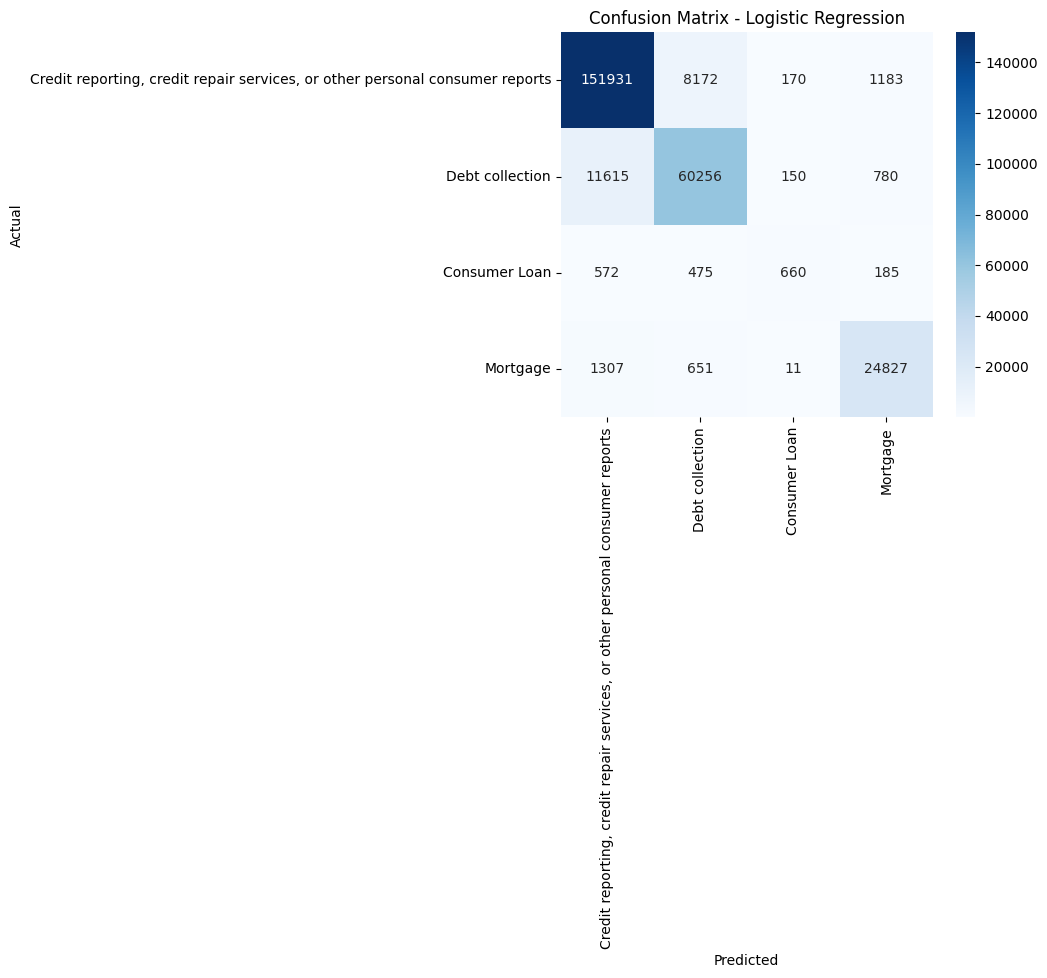

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example: Logistic Regression was best
final_model = LogisticRegression(max_iter=200)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=category_map.keys(),
            yticklabels=category_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [9]:
sample_text = [
    "I am being harassed by debt collectors",
    "My mortgage application was denied unfairly"
]

sample_clean = [clean_text(remove_stopwords(text)) for text in sample_text]
sample_features = vectorizer.transform(sample_clean)
predictions = final_model.predict(sample_features)

for txt, pred in zip(sample_text, predictions):
    print(f"Complaint: {txt} -> Predicted Category: {pred}")


Complaint: I am being harassed by debt collectors -> Predicted Category: 1
Complaint: My mortgage application was denied unfairly -> Predicted Category: 3


In [10]:
import joblib

# Save final model
joblib.dump(final_model, "final_model.pkl")

# Save TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Model and vectorizer saved successfully!")


Model and vectorizer saved successfully!


In [11]:
# Load them back
loaded_model = joblib.load("final_model.pkl")
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Test prediction again
sample_text = ["The debt collector keeps calling me"]
sample_clean = [clean_text(remove_stopwords(text)) for text in sample_text]
sample_features = loaded_vectorizer.transform(sample_clean)
prediction = loaded_model.predict(sample_features)

print("Predicted category:", prediction[0])


Predicted category: 1


In [12]:
# Load them back
loaded_model = joblib.load("final_model.pkl")
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Test prediction again
sample_text = ["i was not able to access my account"]
sample_clean = [clean_text(remove_stopwords(text)) for text in sample_text]
sample_features = loaded_vectorizer.transform(sample_clean)
prediction = loaded_model.predict(sample_features)

print("Predicted category:", prediction[0])


Predicted category: 0
